In [26]:
# !pip install line_profiler
# https://raposa.trade/blog/higher-highs-lower-lows-and-calculating-price-trends-in-python/
# https://dataheadhunters.com/academy/how-to-analyze-market-trends-using-python-step-by-step/


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
from  helpers_db import get_engine, run_sql
engine = get_engine()
ticker = "PYPL"
with engine.begin() as conn:
  data = run_sql(conn, f"SELECT * FROM ticks_1w WHERE symbol='{ticker}' AND dt::date >= '2024-01-01' ORDER BY dt")
  df = pd.DataFrame(data)
  df.set_index("dt", inplace = True)
# print(df)
data = df

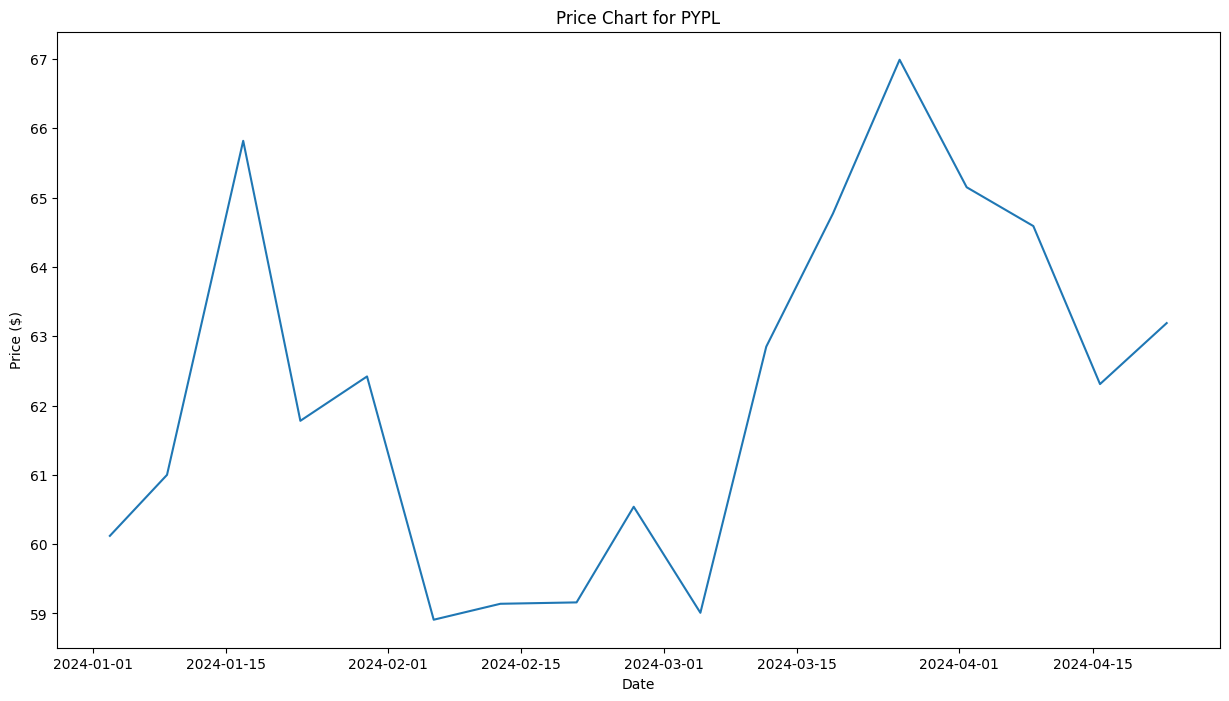

In [29]:
plt.figure(figsize=(15, 8))
plt.plot(data['close'])
plt.title(f'Price Chart for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

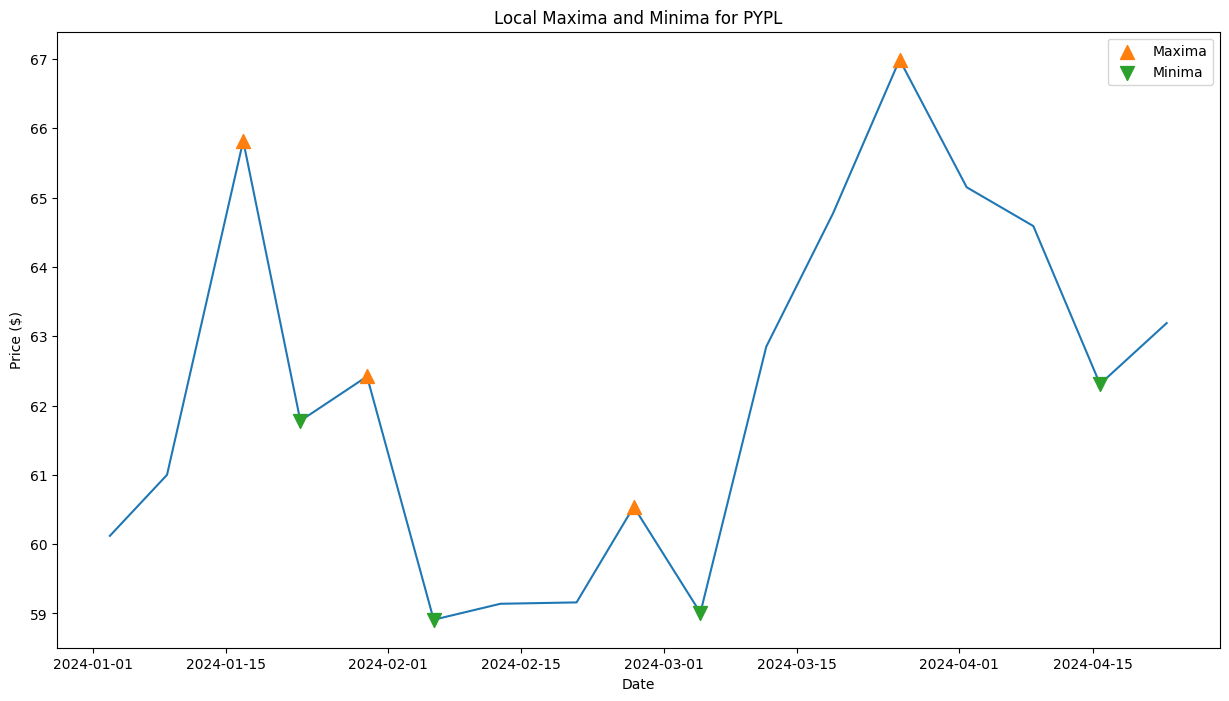

In [30]:
data['local_max'] = data['close'][(data['close'].shift(1) < data['close']) & (data['close'].shift(-1) < data['close'])]
data['local_min'] = data['close'][(data['close'].shift(1) > data['close']) & (data['close'].shift(-1) > data['close'])]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(15, 8))
plt.plot(data['close'], zorder=0)
plt.scatter(data.index, data['local_max'], s=100, label='Maxima', marker='^', c=colors[1])
plt.scatter(data.index, data['local_min'], s=100, label='Minima', marker='v', c=colors[2])
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Local Maxima and Minima for {ticker}')
plt.legend()
plt.show()

In [31]:
from scipy.signal import argrelextrema

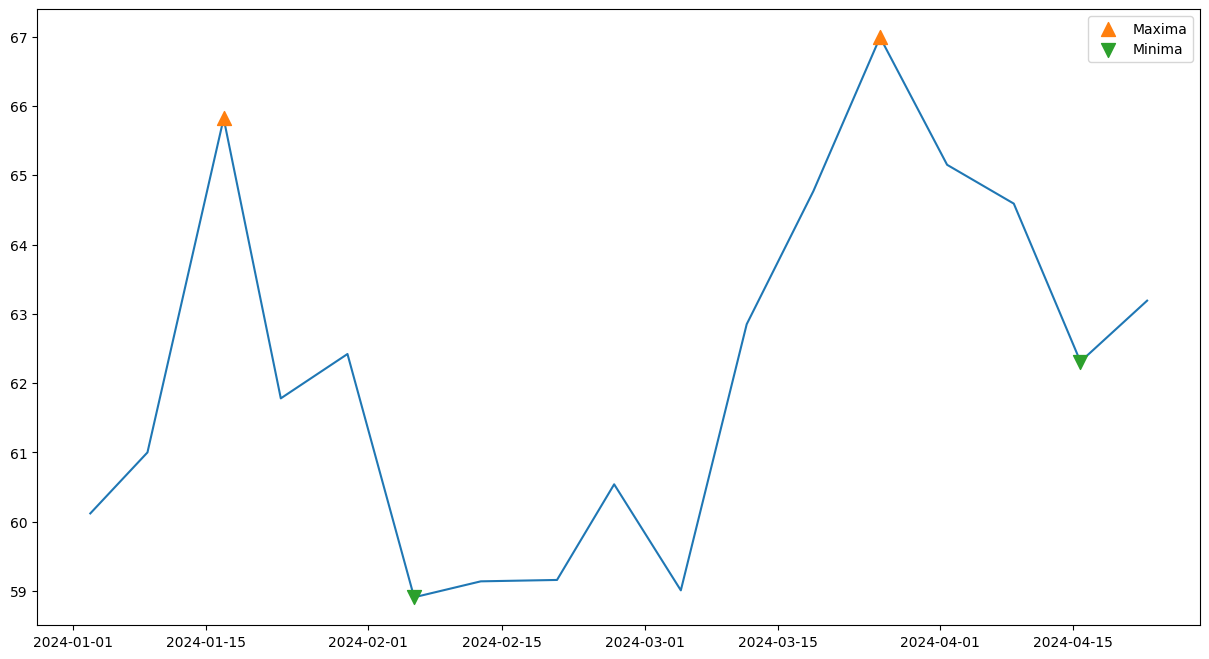

In [32]:
max_idx = argrelextrema(data['close'].values, np.greater, order=5)[0]
min_idx = argrelextrema(data['close'].values, np.less, order=5)[0]
plt.figure(figsize=(15, 8))
plt.plot(data['close'], zorder=0)
plt.scatter(data.iloc[max_idx].index, data.iloc[max_idx]['close'], label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(data.iloc[min_idx].index, data.iloc[min_idx]['close'], label='Minima', s=100, color=colors[2], marker='v')

plt.legend()
plt.show()

In [33]:
from collections import deque
# Get K consecutive higher peaks
K = 2
high_idx = argrelextrema(data['close'].values, np.greater, order=5)[0]
highs = data.iloc[high_idx]['close']

extrema = []
ex_deque = deque(maxlen=K)
for i, idx in enumerate(high_idx):
  if i == 0:
    ex_deque.append(idx)
    continue
  if highs[i] < highs[i-1]:
    ex_deque.clear()

  ex_deque.append(idx)
  if len(ex_deque) == K:
    # K-consecutive higher highs found
    extrema.append(ex_deque.copy())

/var/folders/yy/t103484j0x128qwsqnsn13zm0000gp/T/ipykernel_76082/1895926944.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if highs[i] < highs[i-1]:


In [34]:
print(extrema)

[deque([2, 12], maxlen=2)]


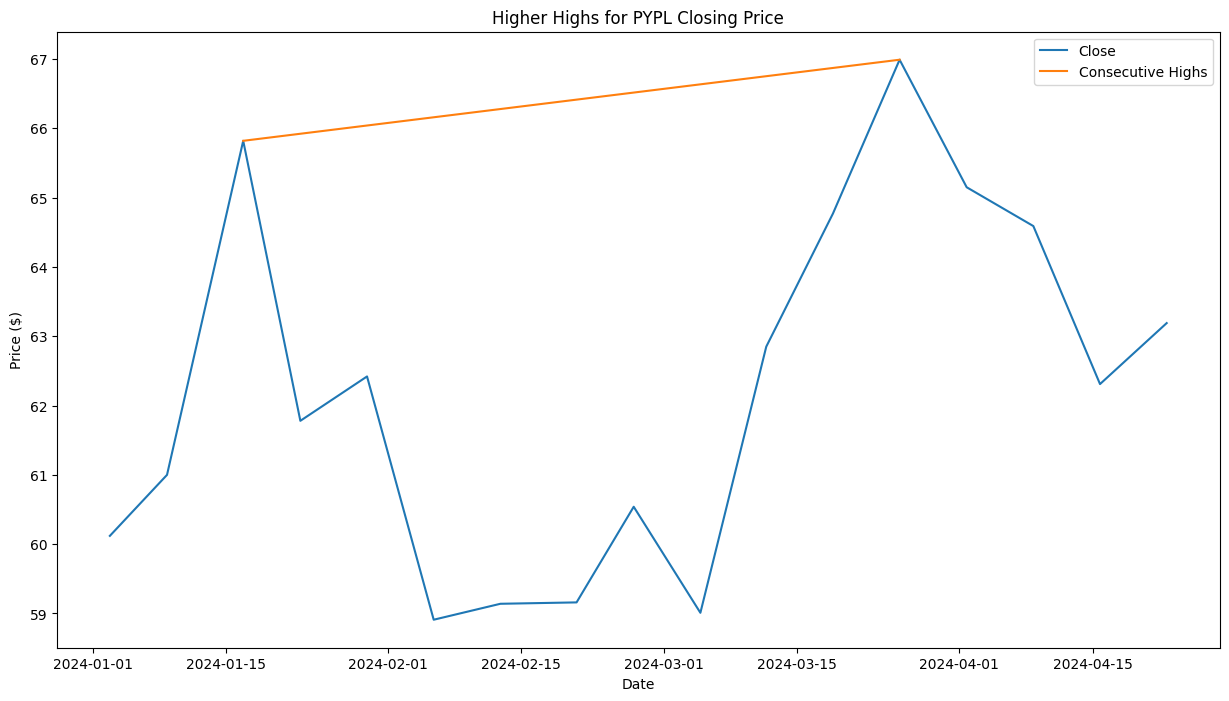

In [35]:
close = data['close'].values
dates = data.index

plt.figure(figsize=(15, 8))
plt.plot(data['close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in extrema]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Higher Highs for {ticker} Closing Price')
plt.legend(['Close', 'Consecutive Highs'])
plt.show()

In [36]:
def getHigherLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be higher.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are higher than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] < lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be lower.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=order)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are lower than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] > highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getHigherHighs(data: np.array, order=5, K=2):
  '''
  Finds consecutive higher highs in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive highs need to be higher.
  '''
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=5)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are higher than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] < highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerLows(data: np.array, order=5, K=2):
  '''
  Finds consecutive lower lows in price pattern.
  Must not be exceeded within the number of periods indicated by the width 
  parameter for the value to be confirmed.
  K determines how many consecutive lows need to be lower.
  '''
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are lower than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] > lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

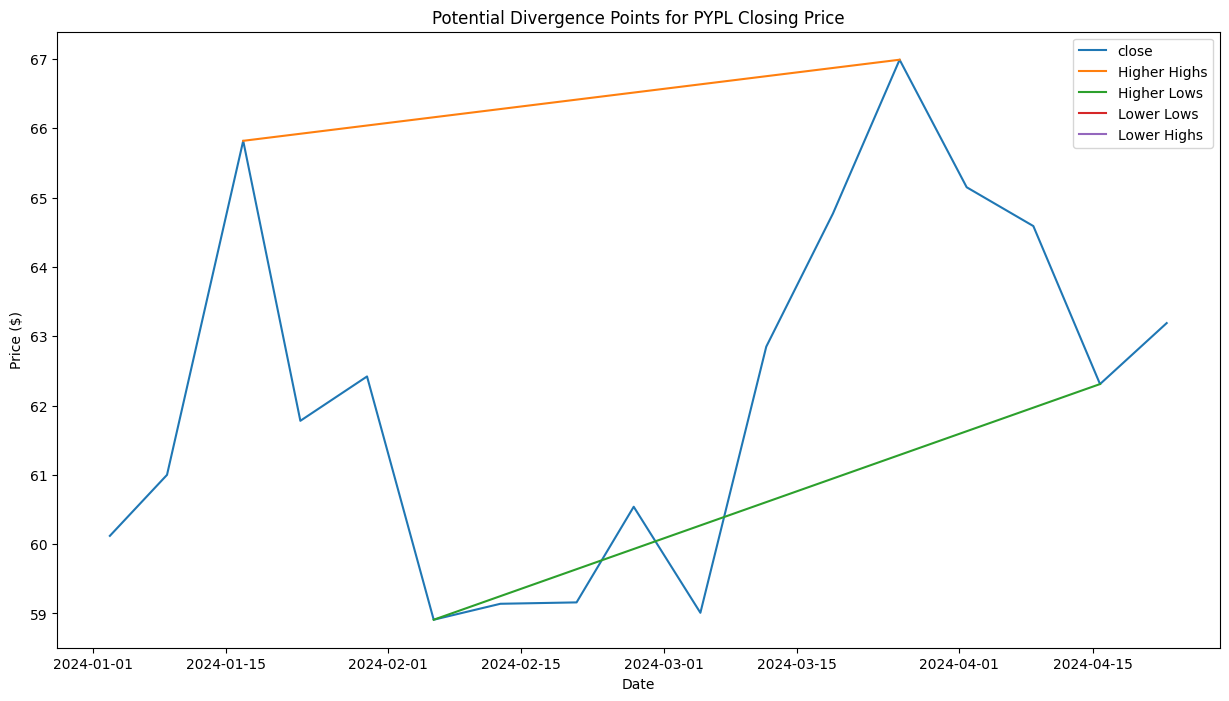

In [37]:
from matplotlib.lines import Line2D

close = data['close'].values
dates = data.index

order = 5
K = 2

hh = getHigherHighs(close, order, K)
hl = getHigherLows(close, order, K)
ll = getLowerLows(close, order, K)
lh = getLowerHighs(close, order, K)

plt.figure(figsize=(15, 8))
plt.plot(data['close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], close[i], c=colors[2]) for i in hl]
_ = [plt.plot(dates[i], close[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], close[i], c=colors[4]) for i in lh]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color=colors[4], label='Lower Highs')
]
plt.legend(handles=legend_elements)
plt.show()

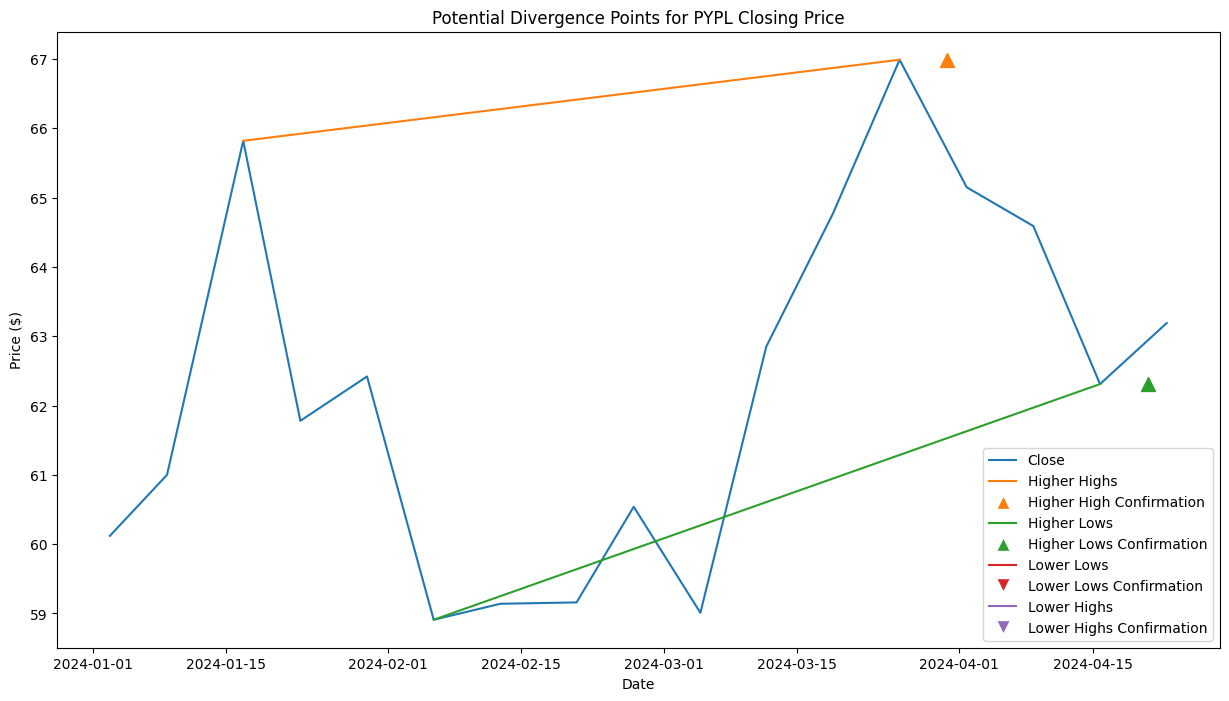

In [38]:
from datetime import timedelta

close = data['close'].values
dates = data.index

order = 5
K = 2

hh = getHigherHighs(close, order, K)
hl = getHigherLows(close, order, K)
ll = getLowerLows(close, order, K)
lh = getLowerHighs(close, order, K)

plt.figure(figsize=(15, 8))
plt.plot(data['close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in hh]
_ = [plt.plot(dates[i], close[i], c=colors[2]) for i in hl]
_ = [plt.plot(dates[i], close[i], c=colors[3]) for i in ll]
_ = [plt.plot(dates[i], close[i], c=colors[4]) for i in lh]

_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], c=colors[1], marker='^', s=100) for i in hh]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], c=colors[2], marker='^', s=100) for i in hl]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], c=colors[3], marker='v', s=100) for i in ll]
_ = [plt.scatter(dates[i[-1]] + timedelta(order), close[i[-1]], c=colors[4], marker='v', s=100) for i in lh]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Potential Divergence Points for {ticker} Closing Price')
legend_elements = [
  Line2D([0], [0], color=colors[0], label='Close'),
  Line2D([0], [0], color=colors[1], label='Higher Highs'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[1],
         label='Higher High Confirmation'),
  Line2D([0], [0], color=colors[2], label='Higher Lows'),
  Line2D([0], [0], color='w',  marker='^',
         markersize=10,
         markerfacecolor=colors[2],
         label='Higher Lows Confirmation'),
  Line2D([0], [0], color=colors[3], label='Lower Lows'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[3],
         label='Lower Lows Confirmation'),
  Line2D([0], [0], color=colors[4], label='Lower Highs'),
  Line2D([0], [0], color='w',  marker='v',
         markersize=10,
         markerfacecolor=colors[4],
         label='Lower Highs Confirmation')
]
plt.legend(handles=legend_elements)
plt.show()